# Catching the Culprit: An analysis of crime clearance rates

# Introduction

> Crime and bad lives are the measure of a State's failure; all crime in the end is the crime of the community.     
> \- H. G. Wells

> In 2010, Baltimore's \[homicide clearance\] rate was 56%, the national average for similarly sized cities, according to statistics compiled by The Sun. But the city's clearance rate has dropped even as violence escalated. In 2015 only 30.5% of cases cleared.
> \- [Baltimore Sun](https://www.baltimoresun.com/maryland/baltimore-city/bs-md-ci-crime-policy-20191230-zk2v2auuhbgq3f7zsh3t7rt6cm-story.html)

The devastating effect of crime on communities can be exacerbated when criminals are unlikely to be held accountable. I looked at 747,658 reports of aggravated assaults and murder from 22 different cities to see what factors were empirically linked to whether or not a police force was able to successfully clear a case.

(Data from The Trace's reporting.)

# Loading Data 

In [33]:
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly_express as px
import random
import seaborn as sns

import eli5
from eli5.sklearn import PermutationImportance
from xgboost import XGBClassifier
import xgboost as xgb

from IPython.display import display
from pandas_profiling import ProfileReport
from pdpbox import pdp
from scipy.stats import uniform, randint

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 85% !important; }</style"))

In [46]:
filename = "C:/Users/ajenk/GitHub/Crime_Data/offenses-standardized.csv"

fields = ["agency_name", "occurred_date", 
          "occurred_time", "firearm_ind", "offense_group", "domestic_violence_ind", "victim_age",
          "victim_race", "victim_ethnicity", "victim_race_condensed", "victim_sex", "clearance_group"]

crime = pd.read_csv(filename, usecols = fields)

#probably want to read in everything then create cardinality and such here

In [35]:
def reset(filename):
   
    crime = pd.read_csv(filename)
    train, test = train_test_split(crime, test_size = .2, random_state = 42)
    
    train = create_binary_target(train)
    test = create_binary_target(test)
    
    return train, test

# Baseline Models

## Mean Classification

I begin by reading in the most usable columns from the data set. The rest of the columns are measures of the target variable, identifiers, or mostly-missing. There may be some useful information to be extracted from these, but the usable ones will be sufficient to fit baseline models.

In [48]:
train, test = train_test_split(crime, test_size = .2, random_state = 42)

In [49]:
train, val = train_test_split(train, test_size = .2, random_state = 42)

In [50]:
train["clearance_group"].value_counts()

Open & No Arrest-Unspecified           284584
Cleared-Arrest & Arrest-Unspecified    148295
Cleared/Closed-Unspecified              25331
Cleared-Ex                              20153
Null, Missing, Unclear                    137
Name: clearance_group, dtype: int64

The measure I'll predict will be whether a case was cleared. I'll turn "clearance group" into a binary variable and drop the few cases which don't have a coherent outcome in the data.

In [51]:
def create_binary_target(df):
    df = df.copy()
    df = df[df["clearance_group"] != "Null, Missing, Unclear"]
    df["cleared"] = ~(df["clearance_group"] == "Open & No Arrest-Unspecified")
    df = df.drop(["clearance_group"], axis = 1)
    return df

In [52]:
train = create_binary_target(train)
val = create_binary_target(val)
test = create_binary_target(test)

In [53]:
train["cleared"].value_counts(normalize = True)

False    0.594912
True     0.405088
Name: cleared, dtype: float64

Only 40.5% of the cases in this data set were actually cleared. Over the course of this analysis, I'll look for predictors that an incident will fall into that 40.5%. For now, I'll note that the 59.5% "uncleared" rate can be treated as a naive model, and thus is a benchmark for accuracy that our model should strive to exceed.

## Baseline Random Forest

Next I fit a quick random forest with no tuning or feature selection.

In [54]:
train.columns

Index(['agency_name', 'occurred_date', 'occurred_time', 'firearm_ind',
       'offense_group', 'domestic_violence_ind', 'victim_age', 'victim_race',
       'victim_ethnicity', 'victim_race_condensed', 'victim_sex', 'cleared'],
      dtype='object')

In [55]:
target = "cleared"
features = train.columns.drop(target).to_list()

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [18]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_jobs = -1),
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['agency_name', 'occurred_date',
                                      'occurred_time', 'firearm_ind',
                                      'offense_group', 'domestic_violence_ind',
                                      'victim_age', 'victim_race',
                                      'victim_ethnicity',
                                      'victim_race_condensed', 'victim_sex'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'agency_name',
                                          'd...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_

In [19]:
pipeline.score(X_val, y_val)

0.6544229515322756

This model manages to obtain 65% accuracy in classifying the validation set. This is better than the mean baseline, but, given the lack of tuning or feature selection/engineering, it's unlikely to be optimal. Future models can be evaluated based on whether they improve performance relative to this model.

## Baseline Logistic

I also want to fit a quick logistic model to the untuned data. This will help guide my intuition for which type of model best fits the data. Additionally, it will help clarify baseline model performance. However, the data in its current form is not well-suited to logistic regression; there are several high-cardinality variables such as raw date and time metrics. I will explore my data and do some preliminary wrangling before testing my first logistic model.

### Logistic Model Preparation: Basic Feature Cleanup

In [123]:
profile = ProfileReport(train, minimal=True).to_notebook_iframe()
profile

In [10]:
def extract_time_and_date(df):
    df["occurred_date"] = pd.to_datetime(df["occurred_date"], infer_datetime_format=True)
    df["occurred_time"] = pd.to_datetime(df["occurred_time"], infer_datetime_format=True)
    
    df["hour"] = df["occurred_time"].dt.hour
    df["hour_zero"] = df["occurred_time"] == pd.to_datetime("00:00")
    df["year"] = df["occurred_date"].dt.year
    df["month"] = df["occurred_date"].dt.month
    
    df = df.drop(["occurred_date", "occurred_time"], axis = 1)
    return df

def clean_age_category(df):
    df["victim_age"] = df["victim_age"].replace({"UNDER 18": "17"})
    df["victim_age"] = df["victim_age"].astype("float")
    df.loc[df["victim_age"] > 100, "victim_age"] = np.NaN
    
    return df

In [11]:
def wrangle(df):
    df = df.copy()
    df = extract_time_and_date(df)
    df = clean_age_category(df)
    
    return df

In [12]:
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [15]:
features = train.columns.drop(target).to_list()

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [25]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((478500, 13), (478500,), (119626, 13), (119626,), (149532, 13), (149532,))

## Fitting Logistic Model

In [26]:
pipeline = make_pipeline(
    ce.OneHotEncoder(),
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression(max_iter = 1000, n_jobs = -1)
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['agency_name', 'firearm_ind',
                                     'offense_group', 'domestic_violence_ind',
                                     'victim_race', 'victim_ethnicity',
                                     'victim_race_condensed', 'victim_sex'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=False, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(a...
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                     

In [27]:
pipeline.score(X_val, y_val)

0.6903850333539532

In [28]:
pipeline.score(X_train, y_train)

0.6909467084639498

A logistic model fits the training data and test data reasonably well. The 69% accuracy serves as a new benchmark. To beat these, we take a deeper dive into our data set.

# Exploring the Data

In [57]:
def generate_most_common(feature, n):
    train_plot = train.copy()
    top_obs = train_plot[feature].value_counts()[:n].index
    train_plot.loc[~train_plot[feature].isin(top_obs), feature] = "OTHER"

    return train_plot


def graph_feature(feature, n):
    train_plot = generate_most_common(feature=feature, n=n)

    fig, ax = plt.subplots(figsize=(25, 10))

    feature_title = feature.replace("_", " ").title()
    sns.countplot(x=train_plot[feature], hue=train_plot[target],
                  order=train_plot[feature].value_counts().index,
                  palette="coolwarm_r")
    ax.tick_params(axis='both', labelsize=16)

    plt.title("Clearance Rates by " + feature_title, fontsize=24)
    plt.xlabel(feature_title, fontsize=20)
    plt.ylabel("Count", fontsize=20)
    plt.legend(("Uncleared", "Cleared"), fontsize=24)

    plt.show()

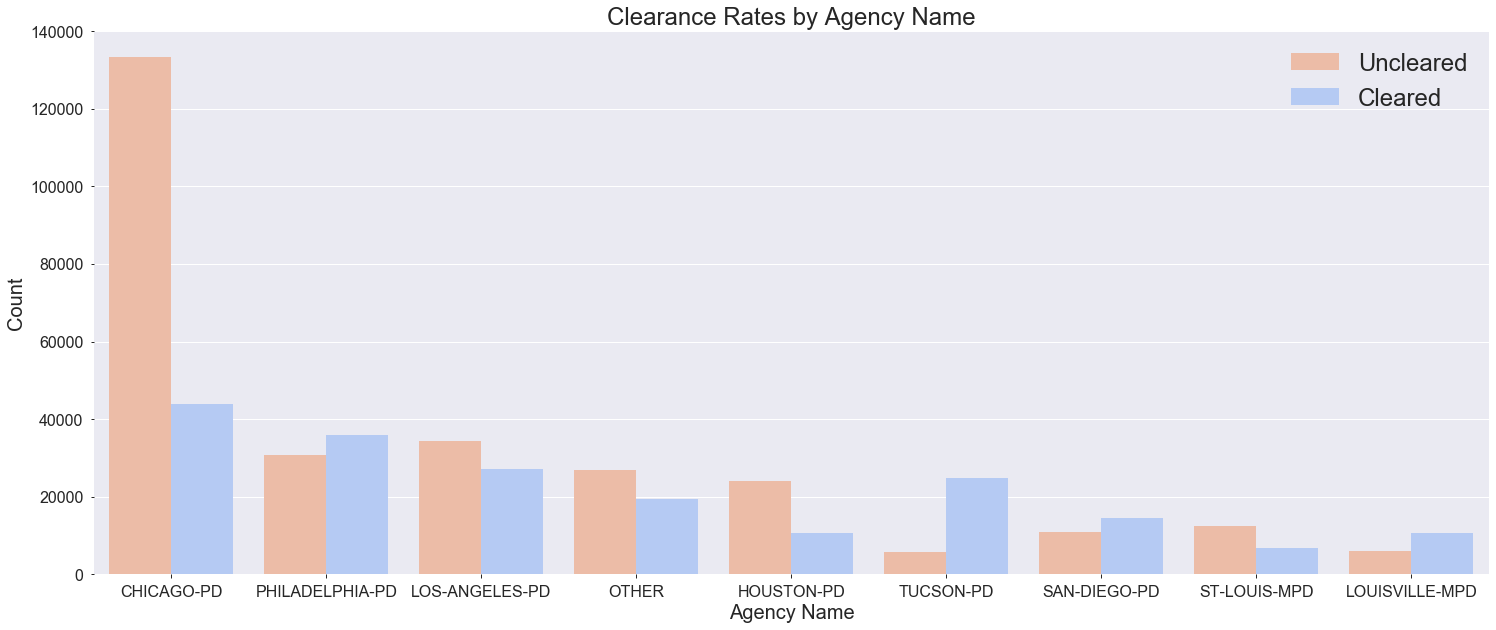

In [58]:
graph_feature("agency_name", 8)

Chicago, notorious for being a city with crime problems, has by far the most crimes in this sample and a clearance rate well below average. It's worth noting that not every agency reported identical data; however, all cities shown on this graph shared homicide and aggravated-assault data, so these numbers should be broadly comparable. It looks like the location of the crime is going to be an important variable for this model.

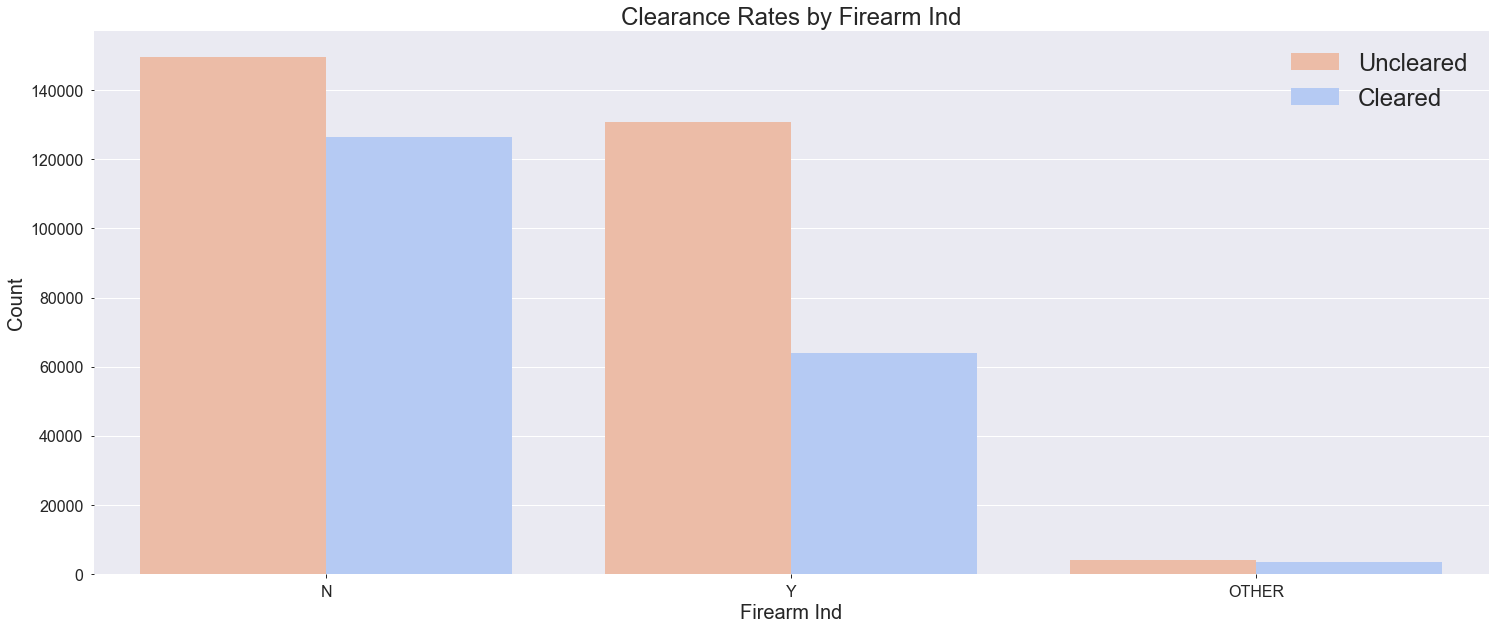

In [60]:
graph_feature("firearm_ind", 2)

Offenses using firearms were cleared at a rate dramatically lower than other crimes.

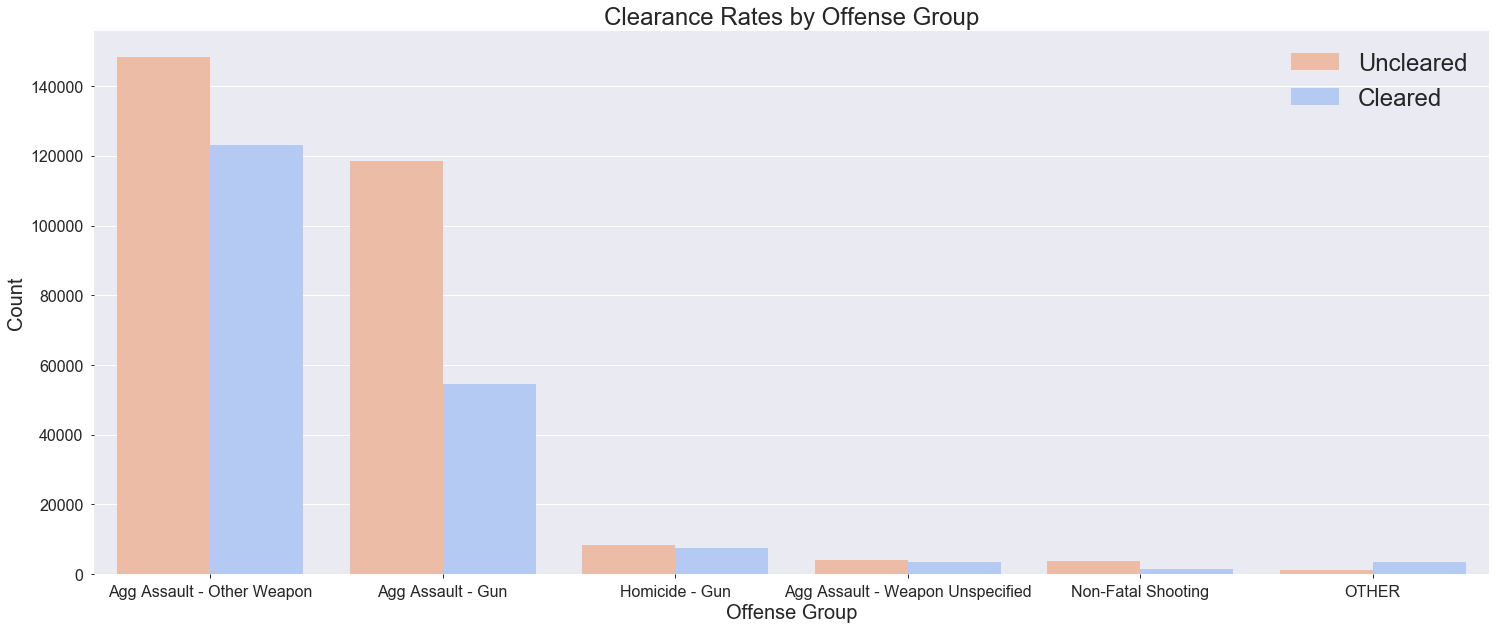

In [61]:
graph_feature("offense_group", 5)

Here we see the effect of firearms broken down by crime. Of note, a substantial majority of homicides committed with non-firearm weapons are cleared.

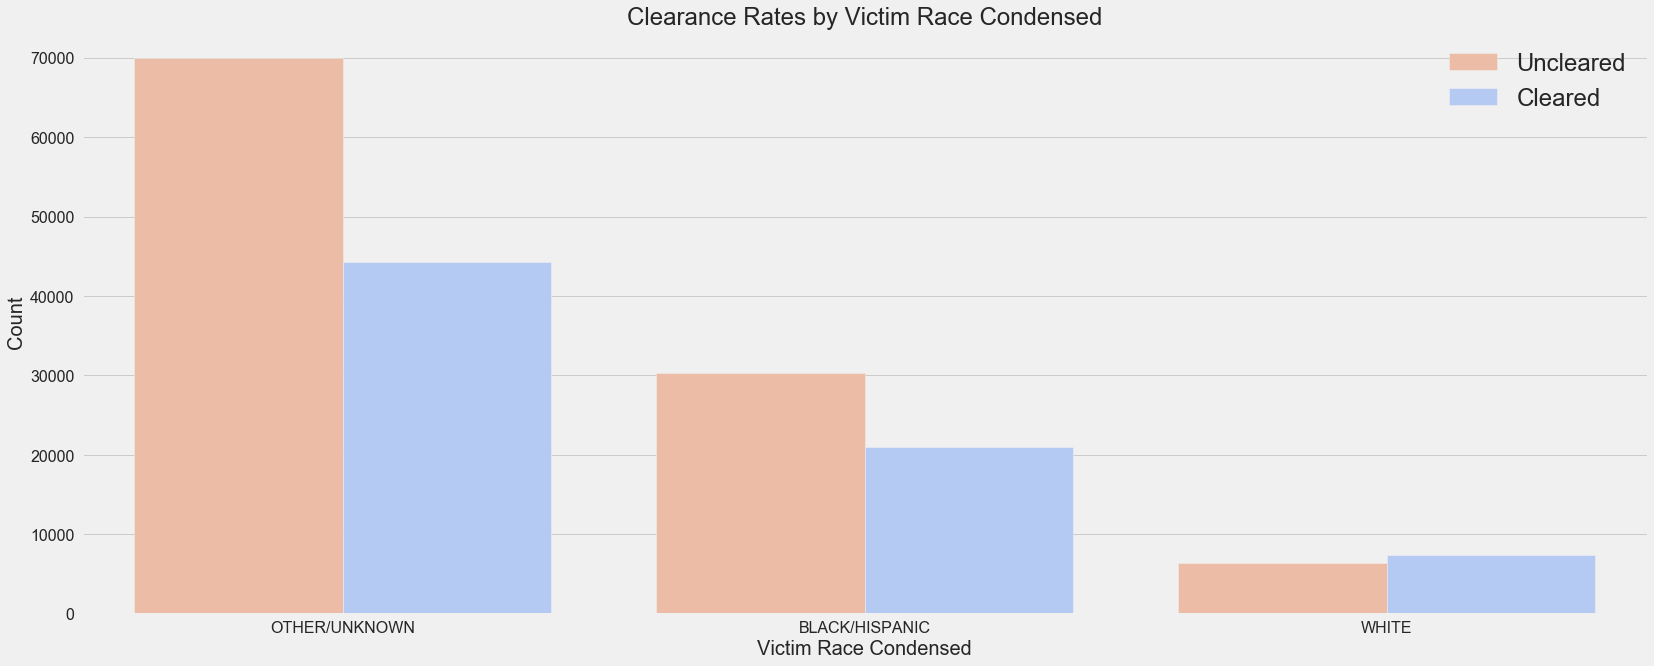

In [110]:
graph_feature("victim_race_condensed", 3)

In [51]:
train, test = reset(filename)

In [60]:
police_data = train.groupby(["agency_name", "offense_group"])["cleared"].mean().reset_index()
police_data = police_data[(police_data["offense_group"] == "Homicide - Gun") 
                          | (police_data["offense_group"] == "Homicide - Other Weapon")]

In [64]:
police_data.sort_values(by = "cleared")

agency_name            offense_group   cleared
0          BALTIMORE-PD           Homicide - Gun  0.261589
55            NEWARK-PD           Homicide - Gun  0.280992
93        WILMINGTON-PD           Homicide - Gun  0.357143
10           CHICAGO-PD           Homicide - Gun  0.384950
49       LOUISVILLE-MPD           Homicide - Gun  0.431373
69        PITTSBURGH-PD           Homicide - Gun  0.437037
3             BOSTON-PD           Homicide - Gun  0.448598
63      PHILADELPHIA-PD           Homicide - Gun  0.468114
82         ST-LOUIS-MPD           Homicide - Gun  0.500000
43       LOS-ANGELES-PD           Homicide - Gun  0.517647
15        CINCINNATI-PD           Homicide - Gun  0.530303
52     NEW-YORK-CITY-PD           Homicide - Gun  0.538462
56            NEWARK-PD  Homicide - Other Weapon  0.555556
26            DALLAS-PD           Homicide - Gun  0.557994
77     SAN-FRANCISCO-PD           Homicide - Gun  0.562963
32           HOUSTON-PD           Homicide - Gun  0.590842
11           CHICAGO-PD  Homicide - Other Weapon  0.647619
94        WILMINGTON-PD  Homicide - Other Weapon  0.666667
29            DENVER-PD           Homicide - Gun  0.677966
33           HOUSTON-PD  Homicide - Other Weapon  0.686957
78     SAN-FRANCISCO-PD  Homicide - Other Weapon  0.701754
74         SAN-DIEGO-PD           Homicide - Gun  0.711864
59           ORLANDO-PD           Homicide - Gun  0.727273
1          BALTIMORE-PD  Homicide - Other Weapon  0.750000
70        PITTSBURGH-PD  Homicide - Other Weapon  0.750000
27            DALLAS-PD  Homicide - Other Weapon  0.757009
44       LOS-ANGELES-PD  Homicide - Other Weapon  0.763158
37        LAS-VEGAS-MPD           Homicide - Gun  0.778626
88            TUCSON-PD           Homicide - Gun  0.779487
30            DENVER-PD  Homicide - Other Weapon  0.785714
53     NEW-YORK-CITY-PD  Homicide - Other Weapon  0.789474
21  COLORADO-SPRINGS-PD           Homicide - Gun  0.800000
50       LOUISVILLE-MPD  Homicide - Other Weapon  0.800000
64      PHILADELPHIA-PD  Homicide - Other Weapon  0.814815
75         SAN-DIEGO-PD  Homicide - Other Weapon  0.842105
83         ST-LOUIS-MPD  Homicide - Other Weapon  0.857143
22  COLORADO-SPRINGS-PD  Homicide - Other Weapon  0.857143
4             BOSTON-PD  Homicide - Other Weapon  0.883721
16        CINCINNATI-PD  Homicide - Other Weapon  0.904762
89            TUCSON-PD  Homicide - Other Weapon  0.911392
38        LAS-VEGAS-MPD  Homicide - Other Weapon  0.924242
60           ORLANDO-PD  Homicide - Other Weapon  0.928571

It looks like homicides in the north, east, and northeast are much less likely to be cleared. Every police department is more likely to clear a homicide not by firearm than one by firearm.

In [76]:
crime_data = train.groupby(["offense_group"])["cleared"].mean().sort_values(ascending = False).reset_index()

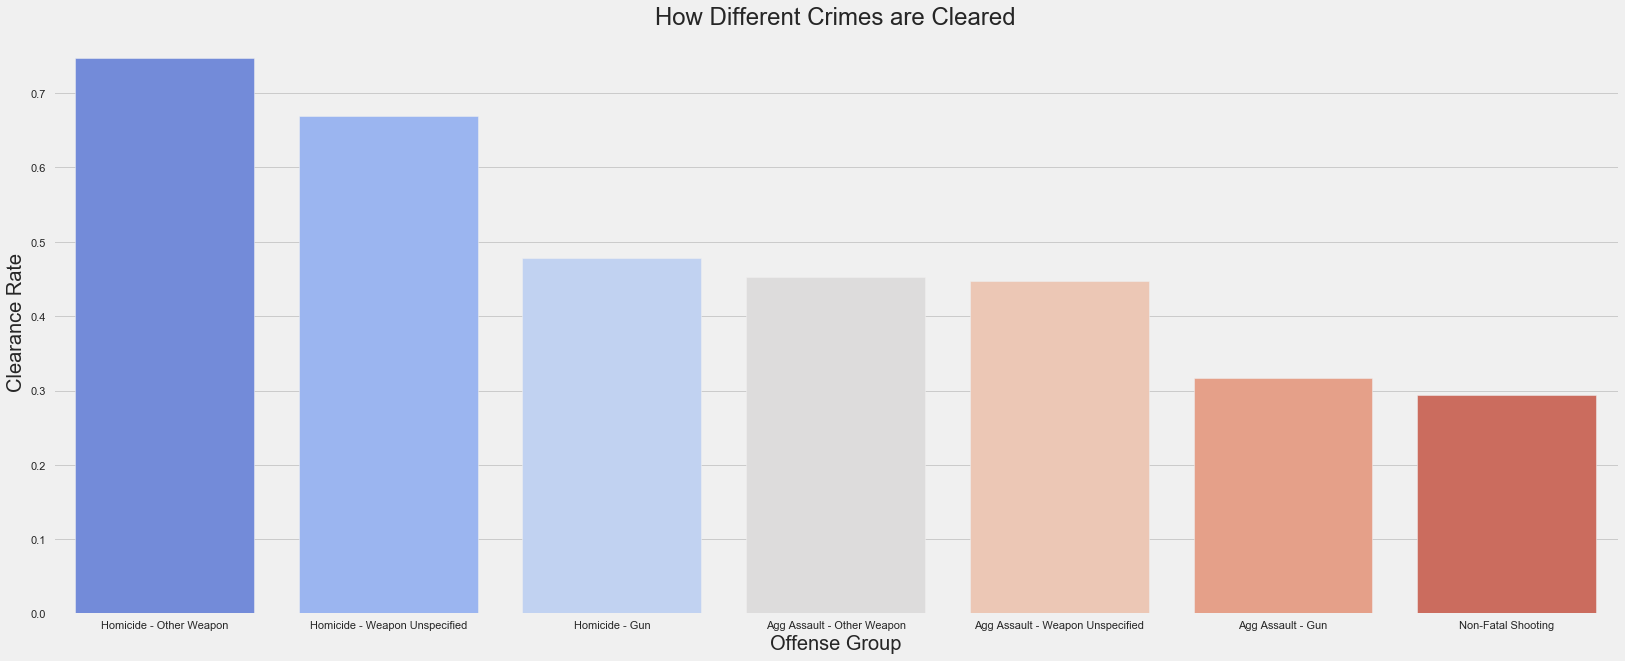

In [101]:
fig, ax = plt.subplots(figsize = (25, 10))

sns.barplot(x = "offense_group", y = "cleared", data = crime_data, palette = "coolwarm")

plt.title("How Different Crimes are Cleared", fontsize = 24)
plt.xlabel("Offense Group", fontsize = 20)
plt.ylabel("Clearance Rate", fontsize = 20)
plt.show()

# Iteration and Model Improvement

Model tuning is an experimental and iterative practice. An exhaustive reproduction of the code I used to select and engineer features, test models on those features, and tune model hyperparameters would be unwieldy. The following code represents examples of the ways in which I iterated through that process and the logic that was involved.

## Hyperparameter Tuning

I begin by exploring the performance of a tuned random forest model on these features.

In [29]:
train, test = reset(filename)

In [31]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state = 42)
)

param_distributions = {
    'simpleimputer__strategy' : ['mean', 'median'],
    'randomforestclassifier__n_estimators': randint(100, 1500),
    'randomforestclassifier__max_depth': [5, 15, 25, 40],
    'randomforestclassifier__min_samples_leaf': randint(3, 7)
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions = param_distributions,
    n_iter = 5,
    cv = 3,
    scoring = 'accuracy',
    verbose = 10,
    return_train_score = True,
    n_jobs = -1
    )

search.fit(X_train_full, y_train_full)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed: 28.0min remaining: 14.0min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed: 31.0min remaining:  7.7min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 37.4min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [32]:
print(search.best_params_)
print(search.best_score_)
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score').T

{'randomforestclassifier__max_depth': 15, 'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__n_estimators': 824, 'simpleimputer__strategy': 'mean'}
0.7049467839261422


4  \
mean_fit_time                                                                             519.255   
std_fit_time                                                                              104.644   
mean_score_time                                                                           38.2211   
std_score_time                                                                            5.41541   
param_randomforestclassifier__max_depth                                                        15   
param_randomforestclassifier__min_samples_leaf                                                  5   
param_randomforestclassifier__n_estimators                                                    824   
param_simpleimputer__strategy                                                                mean   
params                                          {'randomforestclassifier__max_depth': 15, 'ran...   
split0_test_score                                                                        0.704864   
split1_test_score                                                                        0.706112   
split2_test_score                                                                        0.703865   
mean_test_score                                                                          0.704947   
std_test_score                                                                        0.000919201   
rank_test_score                                                                                 1   
split0_train_score                                                                       0.716599   
split1_train_score                                                                       0.719271   
split2_train_score                                                                       0.719767   
mean_train_score                                                                         0.718546   
std_train_score                                                                        0.00139127   

                                                                                                3  \
mean_fit_time                                                                             739.862   
std_fit_time                                                                              2.82357   
mean_score_time                                                                           84.9773   
std_score_time                                                                            9.41514   
param_randomforestclassifier__max_depth                                                        40   
param_randomforestclassifier__min_samples_leaf                                                  5   
param_randomforestclassifier__n_estimators                                                    787   
param_simpleimputer__strategy                                                                mean   
params                                          {'randomforestclassifier__max_depth': 40, 'ran...   
split0_test_score                                                                        0.701263   
split1_test_score                                                                        0.702917   
split2_test_score                                                                        0.701016   
mean_test_score                                                                          0.701732   
std_test_score                                                                         0.00084389   
rank_test_score                                                                                 2   
split0_train_score                                                                       0.757675   
split1_train_score                                                                       0.757764   
split2_train_score                                                                       0.758388   
mean_train_score                                       

The best hyperparameters from this testing turn out to be a max depth of 15 with imputer strategy mean, 5 samples per leaf, and 824 estimators. This produces an accuracy of 70.4%.

## Feature Importances

I use the model selected by the cross-validation process in order to examine feature and permutation importances for the model.

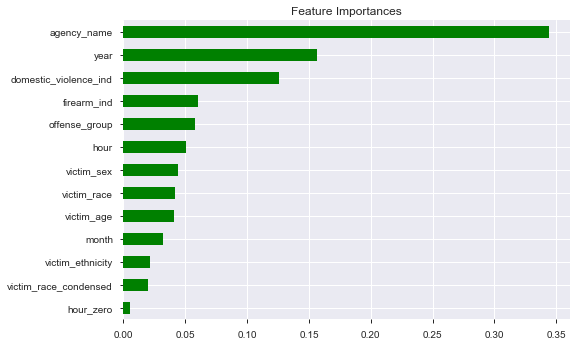

In [33]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy = "mean"),
    RandomForestClassifier(max_depth = 15, n_estimators = 824, 
                           min_samples_leaf = 5, random_state = 42, n_jobs = -1)
    )

pipeline.fit(X_train_full, y_train_full)

rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)
plt.figure()
plt.title("Feature Importances")
importances.sort_values().plot.barh(color='green');


Next I examine the permutation importances for this same model.

In [38]:
transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer()
)

X_train_transformed = transformers.fit_transform(X_train)

model2 = RandomForestClassifier(max_depth = 15, n_estimators = 950, random_state = 42, 
                                min_samples_leaf = 4, n_jobs = -1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [39]:
print(cross_val_score(X_train_transformed, y_train, cv = 3))

0.6954720455306327

In [40]:
permuter = PermutationImportance(
    model2,
    scoring = 'accuracy',
    n_iter = 5,
    random_state = 42
)

permuter.fit(X_val_transformed, y_val)
feature_names = X_val.columns.tolist()
eli5.show_weights(
    permuter,
    top = None,
    feature_names = feature_names
)

# if included in notebook - include it in your story - make sure you actually use it to refine your model

In iterating my random forest model, I also tried KNN and Iterative Imputing -- neither offered a substantial model performance boost while taking substantially more computing time.

# Iterate on Features and Model

## Investigating XGBoost

I check if a gradient-boosted model provides superior performance. I tested and iterated several forms of xgboost, including ones using cross-validations for a larger sample size, and distinctive hyperparameters. In the end, the one with the highest performance was one including some of the low-quality data and with the following hyperparameters, including early stopping to prevent problematic overfitting.

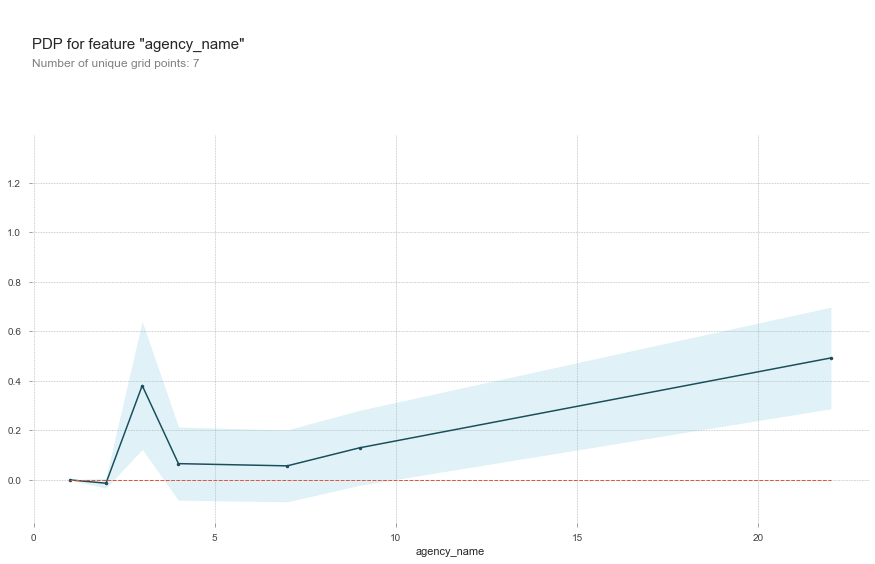

In [23]:
feature = "agency_name"
pdp_dist = pdp.pdp_isolate(model = model3, dataset = X_train_encoded, model_features = features, feature = feature)
pdp.pdp_plot(pdp_dist, feature);

In [124]:
train, test = reset_data(filename)

NameError: name 'reset_data' is not defined

In [36]:
irrelevant = ["row_hash", "agency_ori", "agency_incident_id", "family_violence_ind"]
leakage = ["relationship_to_offender", "arrest_date", "case_status", "arrest_ind",
           "clearance_status", "clearance_date"]
missing = ["family_violence_ind", "inside_outside", "circumstance"]
              

In [40]:
train["gang_activity_ind"].describe()

count     142728
unique        13
top            N
freq       83364
Name: gang_activity_ind, dtype: object

In [41]:
train = train.drop(irrelevant + leakage + missing, axis = 1)

KeyError: "['row_hash' 'agency_ori' 'agency_incident_id' 'family_violence_ind'\n 'relationship_to_offender' 'arrest_date' 'case_status' 'arrest_ind'\n 'clearance_status' 'clearance_date' 'family_violence_ind'\n 'inside_outside' 'circumstance'] not found in axis"

In [42]:
features = train.columns

In [97]:
profile = ProfileReport(train, minimal=True).to_notebook_iframe()
profile

In [43]:
train = wrangle(train)

features = train.columns.drop(target).to_list()

X_train = train[features]
y_train = train[target]

The list of missing values is ugly. However, XGBoost can often deal well with missing data using a kitchen sink approach. 

In [106]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)

dtrain = xgb.DMatrix(X_train_encoded, label = y_train)

params = {
    'n_estimators': 1000,
    'max_depth': 7,
    'learning_rate': .3,
    'n_jobs': -1,
    'eval_metric': 'error'
    }


bst_cv = xgb.cv(params, dtrain, num_boost_round = 1000, nfold = 5,
               early_stopping_rounds=None, as_pandas = True)

bst_cv.sort_values(by = "test-error-mean")

C:\Users\ajenk\Anaconda3\envs\unit2\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ajenk\Anaconda3\envs\unit2\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


train-error-mean  train-error-std  test-error-mean  test-error-std
79           0.255353         0.000495         0.286513        0.002372
78           0.255540         0.000396         0.286519        0.002310
77           0.255760         0.000471         0.286524        0.002306
45           0.265815         0.000784         0.286535        0.002436
80           0.255069         0.000565         0.286574        0.002290
..                ...              ...              ...             ...
995          0.157780         0.000212         0.303812        0.002865
997          0.157636         0.000217         0.303924        0.002871
996          0.157714         0.000204         0.303930        0.002875
999          0.157495         0.000258         0.303958        0.002757
998          0.157582         0.000252         0.303974        0.002785

[1000 rows x 4 columns]

### Various XGB Experiments

In [107]:
params = {
    'n_estimators': 1000,
    'max_depth': 7,
    'learning_rate': .1,
    'n_jobs': -1,
    'eval_metric': 'error'
    }


bst_cv = xgb.cv(params, dtrain, num_boost_round = 1000, nfold = 5,
               early_stopping_rounds=50, as_pandas = True)

bst_cv.sort_values(by = "test-error-mean")

train-error-mean  train-error-std  test-error-mean  test-error-std
129          0.267271         0.000769         0.285631        0.001488
124          0.267879         0.000654         0.285648        0.001487
126          0.267756         0.000705         0.285659        0.001334
105          0.269689         0.000494         0.285665        0.001680
122          0.268064         0.000617         0.285670        0.001626
..                ...              ...              ...             ...
4            0.293324         0.000650         0.295593        0.002197
3            0.293499         0.000760         0.295833        0.002225
2            0.293994         0.000718         0.296162        0.002221
1            0.294849         0.000861         0.297563        0.002183
0            0.296346         0.001351         0.299147        0.001905

[130 rows x 4 columns]

In [108]:
params = {
    'n_estimators': 1000,
    'max_depth': 4,
    'learning_rate': .3,
    'n_jobs': -1,
    'eval_metric': 'error'
    }


bst_cv = xgb.cv(params, dtrain, num_boost_round = 1000, nfold = 5,
               early_stopping_rounds=50, as_pandas = True)

bst_cv.sort_values(by = "test-error-mean")

train-error-mean  train-error-std  test-error-mean  test-error-std
309          0.269509         0.001021         0.285537        0.001505
308          0.269528         0.000967         0.285609        0.001297
307          0.269535         0.000966         0.285615        0.001357
300          0.269795         0.000994         0.285631        0.001568
299          0.269839         0.001007         0.285654        0.001550
..                ...              ...              ...             ...
4            0.301449         0.000569         0.301525        0.002717
3            0.301958         0.000947         0.302205        0.002677
2            0.305000         0.001545         0.305710        0.004206
1            0.309409         0.001778         0.309650        0.003474
0            0.309916         0.000632         0.309934        0.002546

[310 rows x 4 columns]

In [109]:
params = {
    'n_estimators': 1000,
    'max_depth': 4,
    'learning_rate': .1,
    'n_jobs': -1,
    'eval_metric': 'error'
    }


bst_cv = xgb.cv(params, dtrain, num_boost_round = 1000, nfold = 5,
               early_stopping_rounds=50, as_pandas = True)

bst_cv.sort_values(by = "test-error-mean")

train-error-mean  train-error-std  test-error-mean  test-error-std
554          0.275703         0.000891         0.285380        0.002160
552          0.275694         0.000865         0.285403        0.002141
536          0.275980         0.000858         0.285419        0.002194
551          0.275699         0.000862         0.285419        0.002188
553          0.275695         0.000875         0.285425        0.002155
..                ...              ...              ...             ...
4            0.308493         0.000740         0.308584        0.002657
3            0.308793         0.000692         0.308740        0.002720
2            0.309051         0.000785         0.309181        0.002543
1            0.309626         0.000718         0.309655        0.002592
0            0.309916         0.000632         0.309934        0.002546

[555 rows x 4 columns]

In [111]:
params = {
    'n_estimators': 1500,
    'max_depth': 2,
    'learning_rate': .2,
    'n_jobs': -1,
    'eval_metric': 'error'
    }


bst_cv = xgb.cv(params, dtrain, num_boost_round = 1000, nfold = 5,
               early_stopping_rounds=90, as_pandas = True)

bst_cv.sort_values(by = "test-error-mean")

train-error-mean  train-error-std  test-error-mean  test-error-std
914          0.285319         0.000753         0.289705        0.001955
993          0.284892         0.000788         0.289705        0.001939
990          0.284849         0.000755         0.289710        0.001992
992          0.284874         0.000770         0.289711        0.001942
991          0.284853         0.000759         0.289711        0.001963
..                ...              ...              ...             ...
3            0.313818         0.000744         0.313818        0.002976
4            0.315241         0.003541         0.315565        0.002842
2            0.323222         0.000609         0.323222        0.002434
1            0.324142         0.000604         0.324142        0.002417
0            0.356961         0.000706         0.356961        0.002824

[1000 rows x 4 columns]

In [112]:
params = {
    'n_estimators': 1500,
    'max_depth': 3,
    'learning_rate': .2,
    'n_jobs': -1,
    'eval_metric': 'error'
    }


bst_cv = xgb.cv(params, dtrain, num_boost_round = 1000, nfold = 5,
               early_stopping_rounds=90, as_pandas = True)

bst_cv.sort_values(by = "test-error-mean")

train-error-mean  train-error-std  test-error-mean  test-error-std
723          0.275718         0.000805         0.285966        0.001546
721          0.275743         0.000802         0.286011        0.001464
722          0.275719         0.000796         0.286011        0.001510
720          0.275762         0.000789         0.286033        0.001491
711          0.275923         0.000772         0.286117        0.001435
..                ...              ...              ...             ...
6            0.311384         0.000782         0.311341        0.003123
4            0.311692         0.000730         0.311692        0.002920
3            0.311694         0.000749         0.311698        0.002996
2            0.311705         0.000759         0.311709        0.003036
0            0.323173         0.000479         0.323194        0.001916

[724 rows x 4 columns]

In [113]:
params = {
    'n_estimators': 1500,
    'max_depth': 3,
    'learning_rate': .15,
    'n_jobs': -1,
    'eval_metric': 'error'
    }


bst_cv = xgb.cv(params, dtrain, num_boost_round = 1000, nfold = 5,
               early_stopping_rounds=90, as_pandas = True)

bst_cv.sort_values(by = "test-error-mean")

train-error-mean  train-error-std  test-error-mean  test-error-std
437          0.282441         0.000625         0.287836        0.002457
435          0.282544         0.000671         0.287897        0.002499
436          0.282495         0.000644         0.287919        0.002434
430          0.282654         0.000633         0.287936        0.002487
415          0.282922         0.000651         0.287942        0.002358
..                ...              ...              ...             ...
5            0.311702         0.000751         0.311698        0.002998
4            0.311841         0.000778         0.311938        0.002769
2            0.314297         0.003883         0.314722        0.002740
3            0.315212         0.004877         0.315755        0.003417
0            0.323173         0.000479         0.323194        0.001916

[438 rows x 4 columns]

In [114]:
params = {
    'n_estimators': 1100,
    'max_depth': 4,
    'learning_rate': .2,
    'n_jobs': -1,
    'eval_metric': 'error'
    }


bst_cv = xgb.cv(params, dtrain, num_boost_round = 1000, nfold = 5,
               early_stopping_rounds=90, as_pandas = True)

bst_cv.sort_values(by = "test-error-mean")

train-error-mean  train-error-std  test-error-mean  test-error-std
620          0.266309         0.000771         0.284800        0.001829
616          0.266347         0.000771         0.284822        0.001838
612          0.266382         0.000742         0.284833        0.001933
617          0.266341         0.000747         0.284844        0.001821
619          0.266317         0.000765         0.284844        0.001806
..                ...              ...              ...             ...
4            0.305178         0.002423         0.305553        0.004603
3            0.308044         0.000787         0.308344        0.002901
2            0.308534         0.000633         0.308545        0.002541
1            0.309331         0.000527         0.309538        0.003015
0            0.309916         0.000632         0.309934        0.002546

[621 rows x 4 columns]

In [116]:
params = {
    'n_estimators': 750,
    'max_depth': 4,
    'learning_rate': .2,
    'n_jobs': -1,
    'eval_metric': 'error'
    }


bst_cv = xgb.cv(params, dtrain, num_boost_round = 1000, nfold = 5,
               early_stopping_rounds=90, as_pandas = True)

bst_cv.sort_values(by = "test-error-mean")

train-error-mean  train-error-std  test-error-mean  test-error-std
620          0.266309         0.000771         0.284800        0.001829
616          0.266347         0.000771         0.284822        0.001838
612          0.266382         0.000742         0.284833        0.001933
617          0.266341         0.000747         0.284844        0.001821
619          0.266317         0.000765         0.284844        0.001806
..                ...              ...              ...             ...
4            0.305178         0.002423         0.305553        0.004603
3            0.308044         0.000787         0.308344        0.002901
2            0.308534         0.000633         0.308545        0.002541
1            0.309331         0.000527         0.309538        0.003015
0            0.309916         0.000632         0.309934        0.002546

[621 rows x 4 columns]

In [117]:
params = {
    'n_estimators': 750,
    'max_depth': 4,
    'learning_rate': .25,
    'n_jobs': -1,
    'eval_metric': 'error'
    }


bst_cv = xgb.cv(params, dtrain, num_boost_round = 1000, nfold = 5,
               early_stopping_rounds=90, as_pandas = True)

bst_cv.sort_values(by = "test-error-mean")

train-error-mean  train-error-std  test-error-mean  test-error-std
226          0.274681         0.000472         0.285654        0.002352
221          0.274927         0.000495         0.285726        0.002154
217          0.275172         0.000437         0.285737        0.002261
225          0.274709         0.000452         0.285804        0.002331
216          0.275217         0.000423         0.285804        0.002294
..                ...              ...              ...             ...
4            0.306163         0.002307         0.306597        0.004461
3            0.307063         0.000157         0.307351        0.003551
2            0.307097         0.001525         0.307457        0.003489
1            0.309436         0.000687         0.309633        0.003655
0            0.309916         0.000632         0.309934        0.002546

[227 rows x 4 columns]

## SKL XGBoost

Note that I tried cross-validation and a wide array of parameters and these seemed to be the best

### Features

In [46]:
train, val = train_test_split(train, test_size = .2, random_state = 42)

In [52]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [48]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model3 = XGBClassifier(
    n_estimators = 1000,
    max_depth = 4,
    learning_rate = .2,
    n_jobs = -1,)


eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model3.fit(X_train_encoded,
          y_train,
          eval_set = eval_set,
          eval_metric = 'error',
          early_stopping_rounds = 90
          )

[0]	validation_0-error:0.307112	validation_1-error:0.307701
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90 rounds.
[1]	validation_0-error:0.306435	validation_1-error:0.307082
[2]	validation_0-error:0.307112	validation_1-error:0.307701
[3]	validation_0-error:0.3046	validation_1-error:0.305477
[4]	validation_0-error:0.302892	validation_1-error:0.303713
[5]	validation_0-error:0.305954	validation_1-error:0.306706
[6]	validation_0-error:0.30475	validation_1-error:0.306012
[7]	validation_0-error:0.301223	validation_1-error:0.303053
[8]	validation_0-error:0.301768	validation_1-error:0.303371
[9]	validation_0-error:0.300727	validation_1-error:0.302451
[10]	validation_0-error:0.299461	validation_1-error:0.301239
[11]	validation_0-error:0.299557	validation_1-error:0.30169
[12]	validation_0-error:0.298832	validation_1-error:0.300562
[13]	validation_0-error:0.298836	validation_1-error:0.300787

[132]	validation_0-error:0.283513	validation_1-error:0.287003
[133]	validation_0-error:0.283469	validation_1-error:0.287011
[134]	validation_0-error:0.283279	validation_1-error:0.28666
[135]	validation_0-error:0.283279	validation_1-error:0.286635
[136]	validation_0-error:0.283195	validation_1-error:0.286652
[137]	validation_0-error:0.283206	validation_1-error:0.286618
[138]	validation_0-error:0.283216	validation_1-error:0.286602
[139]	validation_0-error:0.283179	validation_1-error:0.286577
[140]	validation_0-error:0.283154	validation_1-error:0.286635
[141]	validation_0-error:0.283145	validation_1-error:0.286643
[142]	validation_0-error:0.283135	validation_1-error:0.286719
[143]	validation_0-error:0.283158	validation_1-error:0.286668
[144]	validation_0-error:0.283041	validation_1-error:0.286602
[145]	validation_0-error:0.28303	validation_1-error:0.286627
[146]	validation_0-error:0.282995	validation_1-error:0.286635
[147]	validation_0-error:0.28288	validation_1-error:0.286518
[148]	valid

[265]	validation_0-error:0.279808	validation_1-error:0.283667
[266]	validation_0-error:0.279801	validation_1-error:0.283667
[267]	validation_0-error:0.279776	validation_1-error:0.283634
[268]	validation_0-error:0.279778	validation_1-error:0.283609
[269]	validation_0-error:0.279783	validation_1-error:0.283609
[270]	validation_0-error:0.279707	validation_1-error:0.283626
[271]	validation_0-error:0.279707	validation_1-error:0.283626
[272]	validation_0-error:0.279745	validation_1-error:0.283667
[273]	validation_0-error:0.279697	validation_1-error:0.283676
[274]	validation_0-error:0.279678	validation_1-error:0.283609
[275]	validation_0-error:0.279676	validation_1-error:0.283667
[276]	validation_0-error:0.279691	validation_1-error:0.283626
[277]	validation_0-error:0.27968	validation_1-error:0.283667
[278]	validation_0-error:0.279676	validation_1-error:0.283768
[279]	validation_0-error:0.279674	validation_1-error:0.283776
[280]	validation_0-error:0.279678	validation_1-error:0.283693
[281]	val

[398]	validation_0-error:0.277964	validation_1-error:0.282714
[399]	validation_0-error:0.27796	validation_1-error:0.282714
[400]	validation_0-error:0.277912	validation_1-error:0.282689
[401]	validation_0-error:0.277902	validation_1-error:0.282723
[402]	validation_0-error:0.277914	validation_1-error:0.282714
[403]	validation_0-error:0.277862	validation_1-error:0.282698
[404]	validation_0-error:0.277864	validation_1-error:0.282698
[405]	validation_0-error:0.277854	validation_1-error:0.282673
[406]	validation_0-error:0.277847	validation_1-error:0.282773
[407]	validation_0-error:0.277827	validation_1-error:0.282773
[408]	validation_0-error:0.277831	validation_1-error:0.282773
[409]	validation_0-error:0.277824	validation_1-error:0.282748
[410]	validation_0-error:0.277818	validation_1-error:0.282748
[411]	validation_0-error:0.277818	validation_1-error:0.282756
[412]	validation_0-error:0.277804	validation_1-error:0.282756
[413]	validation_0-error:0.277804	validation_1-error:0.282756
[414]	val

[531]	validation_0-error:0.276556	validation_1-error:0.282497
[532]	validation_0-error:0.276577	validation_1-error:0.282539
[533]	validation_0-error:0.276548	validation_1-error:0.282447
[534]	validation_0-error:0.276556	validation_1-error:0.282455
[535]	validation_0-error:0.276543	validation_1-error:0.282388
[536]	validation_0-error:0.276552	validation_1-error:0.28238
[537]	validation_0-error:0.276545	validation_1-error:0.28238
[538]	validation_0-error:0.276495	validation_1-error:0.282313
[539]	validation_0-error:0.276495	validation_1-error:0.282338
[540]	validation_0-error:0.276491	validation_1-error:0.282305
[541]	validation_0-error:0.276483	validation_1-error:0.282296
[542]	validation_0-error:0.276466	validation_1-error:0.282296
[543]	validation_0-error:0.276456	validation_1-error:0.282338
[544]	validation_0-error:0.276382	validation_1-error:0.282363
[545]	validation_0-error:0.276334	validation_1-error:0.282313
[546]	validation_0-error:0.276322	validation_1-error:0.282322
[547]	vali

[664]	validation_0-error:0.275384	validation_1-error:0.282146
[665]	validation_0-error:0.275377	validation_1-error:0.282188
[666]	validation_0-error:0.275373	validation_1-error:0.282171
[667]	validation_0-error:0.275348	validation_1-error:0.282263
[668]	validation_0-error:0.275302	validation_1-error:0.282355
[669]	validation_0-error:0.275304	validation_1-error:0.282305
[670]	validation_0-error:0.275246	validation_1-error:0.282305
[671]	validation_0-error:0.275256	validation_1-error:0.282296
[672]	validation_0-error:0.275229	validation_1-error:0.282238
[673]	validation_0-error:0.275214	validation_1-error:0.282271
[674]	validation_0-error:0.275212	validation_1-error:0.282271
[675]	validation_0-error:0.275246	validation_1-error:0.282305
[676]	validation_0-error:0.27522	validation_1-error:0.282271
[677]	validation_0-error:0.275195	validation_1-error:0.28228
[678]	validation_0-error:0.275258	validation_1-error:0.282363
[679]	validation_0-error:0.275241	validation_1-error:0.282313
[680]	vali

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Our best XGBoost model with chosen hyperparameters and a more inclusive approach to the data gives a training accuracy of .724 and a validation accuracy of .718. These is the best model we have thus far.

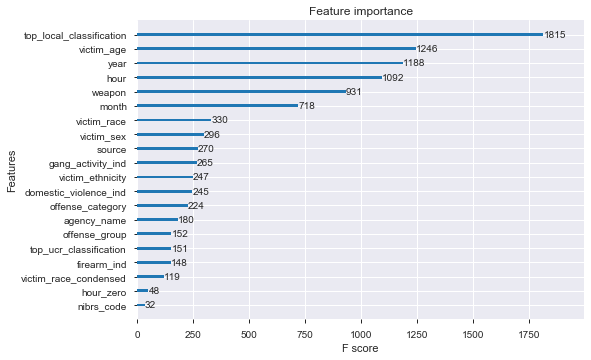

In [49]:
xgb.plot_importance(model3);

"Hour zero" and "nibrs code" both don't seem to be adding much to the model. Re-running the model with those two removed, the validation accuracy is essentially identical. Thus, I'll remove them.

In [ ]:
xgb.plot_importance(model3);

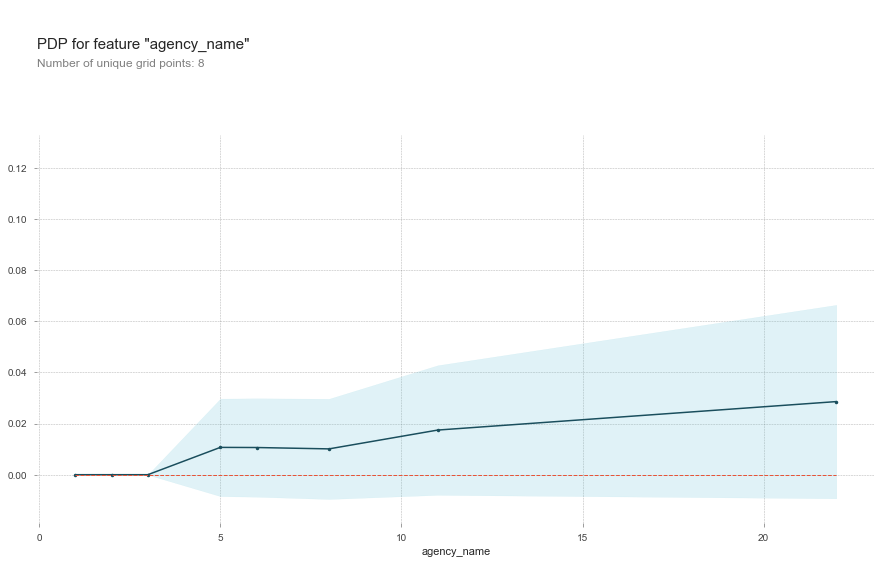

In [131]:
%matplotlib inline
feature = "agency_name"
pdp_dist = pdp.pdp_isolate(model = model3, 
                                 dataset = X_train_encoded, 
                                 model_features = features, 
                                 feature = feature)
pdp.pdp_plot(pdp_dist, feature);

In [133]:
feature = "victim_age"
pdp_dist = pdp.pdp_isolate(model = model3, 
                                 dataset = X_train_encoded, 
                                 model_features = features, 
                                 feature = feature)
pdp.pdp_plot(pdp_dist, feature);

ValueError: No objects to concatenate

Building models is an iterative process: new features and model tweaks are tested apart and together; the ones that are useful are kept; the ones that add little value are discarded. For legibility and organization, I omit most of the actual code involved.

I tested features including interactions between variables, flags for major holidays (where crime is typically more common), and various derived items. Ultimately, "day of the week" was the only feature I found that added substantial predictive value in a random forest model. A tuned random forest was powerful and flexible enough that it captured feature interactions in the data set itself.

In [107]:
train, test = reset(filename)
irrelevant = ["row_hash", "agency_ori", "agency_incident_id", "family_violence_ind"]
leakage = ["relationship_to_offender", "arrest_date", "case_status", "arrest_ind",
           "clearance_status", "clearance_date"]
missing = ["family_violence_ind", "inside_outside", "circumstance"]
nonpredictive = ["nibrs_code"]

In [108]:
train = train.drop(irrelevant + leakage + missing + nonpredictive, axis = 1)
test = test.drop(irrelevant + leakage + missing + nonpredictive, axis = 1)

In [109]:
def extract_datetime_info(df):
    df["occurred_date"] = pd.to_datetime(df["occurred_date"], infer_datetime_format=True)
    df["occurred_time"] = pd.to_datetime(df["occurred_time"], infer_datetime_format=True)
    
    df["hour"] = df["occurred_time"].dt.hour
    df["year"] = df["occurred_date"].dt.year
    df["month"] = df["occurred_date"].dt.month
    df["day"] = df["occurred_date"].dt.dayofweek
    
    df = df.drop(["occurred_date", "occurred_time"], axis = 1)
    
    return df

In [110]:
def clean_age_category(df):
    df["victim_age"] = df["victim_age"].replace({"UNDER 18": "17"})
    df["victim_age"] = df["victim_age"].astype("float")
    df.loc[df["victim_age"] > 100, "victim_age"] = np.NaN
    
    return df

In [111]:
def combine_categoricals(df):
    df["domestic_violence_ind"] = df["domestic_violence_ind"].replace(
        {"MISSING-JOIN": "MISSING"})

    df["BLACK"] = (df["victim_race"].str.contains(
        "BLACK")) | (df["victim_race"] == "B")
    df.loc[df["BLACK"], "victim_race_condensed"] = "BLACK"
    df["victim_race_condensed"] = df["victim_race_condensed"].replace(
        {"BLACK/HISPANIC": "HISPANIC"})
    df = df.drop(["BLACK"], axis = 1)
    
    df["victim_sex"] = df["victim_sex"].replace({"M": "MALE", "F": "FEMALE"})

    return df

In [112]:
def wrangle_more(df):
    df = df.copy()
    df = extract_datetime_info(df)
    df = clean_age_category(df)
    df = combine_categoricals(df)
    
    return(df)

In [113]:
train = wrangle_more(train)
test = wrangle_more(test)

In [114]:
train.shape

(597937, 20)

In [73]:
train.columns

Index(['source', 'agency_name', 'offense_category', 'top_ucr_classification',
       'top_local_classification', 'weapon', 'firearm_ind', 'offense_group',
       'domestic_violence_ind', 'gang_activity_ind', 'victim_age',
       'victim_race', 'victim_ethnicity', 'victim_race_condensed',
       'victim_sex', 'cleared', 'hour', 'year', 'month', 'day',
       'fourth_of_july', 'nye', 'new_years'],
      dtype='object')

## Exploration

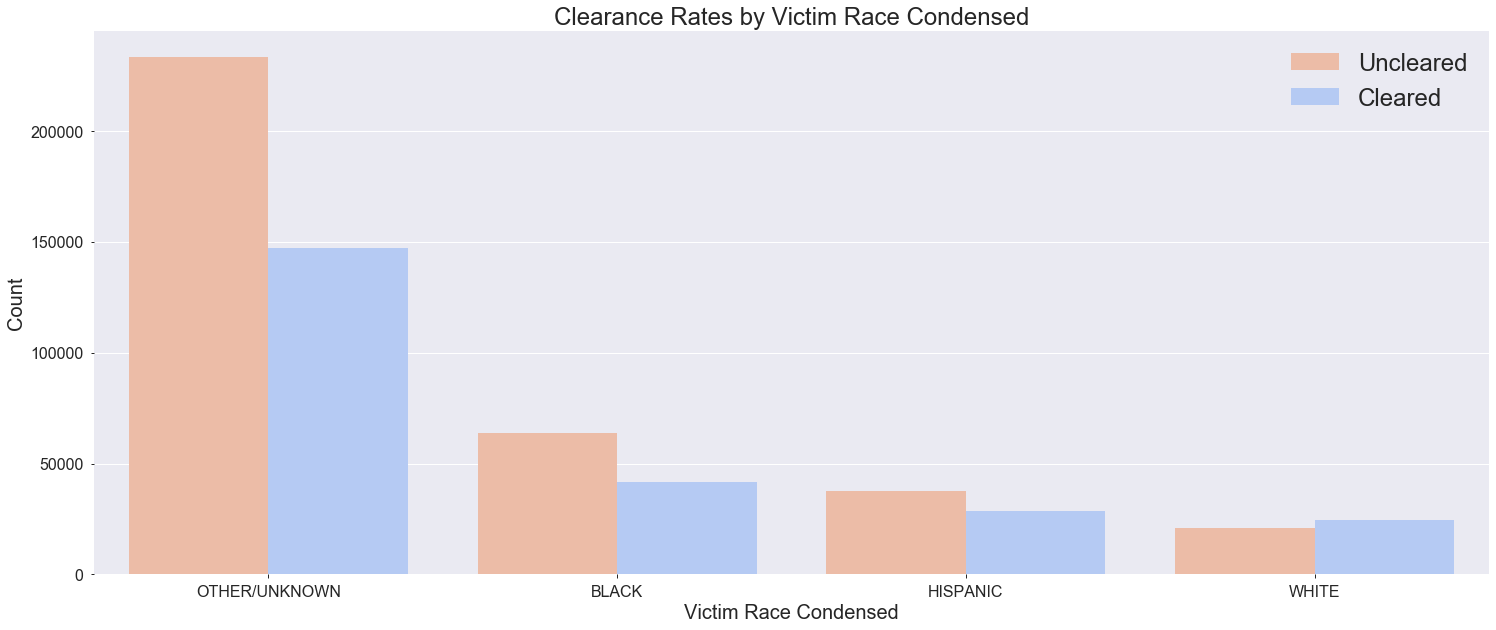

In [74]:
graph_feature("victim_race_condensed", 4)

In [85]:
age_groups = train.groupby(["victim_age", "victim_race_condensed", "firearm_ind"])["cleared"].mean().reset_index()

In [86]:
px.line(age_groups, x = "victim_age", y = "cleared")

In [71]:
train.groupby("victim_age").count()

source  agency_name  offense_category  top_ucr_classification  \
victim_age                                                                  
0.0           1391         1391              1011                    1257   
1.0            507          507               346                     363   
2.0            413          413               266                     260   
3.0            348          348               211                     224   
4.0            304          304               191                     173   
...            ...          ...               ...                     ...   
96.0             8            8                 7                       7   
97.0            14           14                13                       7   
98.0             3            3                 3                       2   
99.0            62           62                59                      62   
100.0            1            1                 1                       0   

            top_local_classification  weapon  firearm_ind  offense_group  \
victim_age                                                                 
0.0                              882    1240         1391           1391   
1.0                              329     427          507            507   
2.0                              233     327          413            413   
3.0                              177     272          348            348   
4.0                              165     227          304            304   
...                              ...     ...          ...            ...   
96.0                               6       6            8              8   
97.0                              13       9           14             14   
98.0                               2       2            3              3   
99.0                              59      61           62             62   
100.0                              1       0            1              1   

            domestic_violence_ind  gang_activity_ind  ...  victim_sex  \
victim_age                                            ...               
0.0                           954                142  ...        1318   
1.0                           229                215  ...         505   
2.0                           213                141  ...         412   
3.0                           173                121  ...         348   
4.0                           164                 94  ...         304   
...                           ...                ...  ...         ...   
96.0                            2                  6  ...           8   
97.0                            8                  7  ...          14   
98.0                            2                  2  ...           3   
99.0                           43                 16  ...          62   
100.0                           1                  0  ...           1   

            cleared  hour  year  month   day  fourth_of_july   nye  new_years  \
victim_age                                                                      
0.0            1391  1301  1389   1389  1389            1391  1391       1391   
1.0             507   476   507    507   507             507   507        507   
2.0             413   379   413    413   413             413   413        413   
3.0             348   307   348    348   348             348   348        348   
4.0             304   285   304    304   304             304   304        304   
...             ...   ...   ...    ...   ...             ...   ...        ...   
96.0              8     7     8      8     8               8     8          8   
97.0             14    12    14     14    14              14    14         14   
98.0              3     2     3      3     3               3     3          3   
99.0             62    62    62     62    62              62    62         62   
100.0             1     1     1      1     1               1     1          1   

            BLACK

In [ ]:
police_data = train.groupby(["agency_name", "offense_group"])["cleared"].mean().reset_index()
police_data = police_data[(police_data["offense_group"] == "Homicide - Gun") 
                          | (police_data["offense_group"] == "Homicide - Other Weapon")]

In [66]:
age_groups

<bound method Series.reset_index of victim_age
0.0      0.645579
1.0      0.619329
2.0      0.581114
3.0      0.520115
4.0      0.493421
           ...   
96.0     0.625000
97.0     0.428571
98.0     0.333333
99.0     0.548387
100.0    1.000000
Name: cleared, Length: 101, dtype: float64>

In [101]:
train_plot = train[["agency_name", "cleared", "firearm_ind"]]

In [102]:
train_plot = train_plot[train_plot["firearm_ind"].isin(["Y", "N"])]

In [104]:
train_plot["firearm_present"] = train_plot["firearm_ind"] == "Y"

In [106]:
train_plot.groupby("agency_name")["firearm_present"].mean()

agency_name
BALTIMORE-PD           0.950300
BOSTON-PD              0.804225
CHICAGO-PD             0.329782
CINCINNATI-PD          0.533918
COLORADO-SPRINGS-PD    0.376147
DALLAS-PD              0.642050
DENVER-PD              0.688811
HOUSTON-PD             0.983213
LAS-VEGAS-MPD          0.307362
LOS-ANGELES-PD         0.290345
LOUISVILLE-MPD         0.364319
NEW-ORLEANS-PD         1.000000
NEW-YORK-CITY-PD       0.590717
NEWARK-PD              0.929064
ORLANDO-PD             0.684564
PHILADELPHIA-PD        0.311296
PITTSBURGH-PD          0.421053
SAN-DIEGO-PD           0.137591
SAN-FRANCISCO-PD       0.872204
ST-LOUIS-MPD           0.993907
TUCSON-PD              0.411462
WILMINGTON-PD          0.467395
Name: firearm_present, dtype: float64

In [93]:
monthly = train.groupby("month").count().reset_index()
monthly["count"] = monthly["agency_name"]

In [95]:
px.bar(monthly, x = "month", y = "count")

ax.set_xticks(range(1, 13))
ax.xticklabels(["January", "February", "March", "April",
               "May", "June", "July", "August",
               "September", "October", "November",
               "December"])

In [ ]:
fig, ax = plt.subplots(figsize = (25, 10))

    sns.lineplot(x = "victim_age", y = "cleared", data = train)
    ax.tick_params(axis = 'both', labelsize = 16)
    plt.title(feature.replace("_", " ").title())
    plt.show()

In [75]:
train["victim_sex"].value_counts()

MALE             148955
FEMALE            78347
UNDER 18           1991
U                   356
UNKNOWN             249
X                   197
MISSING              18
OTH                  17
H                     7
UNCLEAR               5
TRANSGENDERED         2
M                     1
TEST                  1
UNK                   1
Name: victim_sex, dtype: int64

In [24]:
train.groupby("agency_name").apply(lambda x: (x.isnull().sum())/len(x))

agency_name  occurred_date  occurred_time  firearm_ind  \
agency_name                                                                   
BALTIMORE-PD                 0.0       0.000000       0.716792          0.0   
BOSTON-PD                    0.0       0.000000       0.010471          0.0   
CHICAGO-PD                   0.0       0.000090       0.000090          0.0   
CINCINNATI-PD                0.0       0.000000       0.000000          0.0   
COLORADO-SPRINGS-PD          0.0       0.000000       1.000000          0.0   
DALLAS-PD                    0.0       0.000000       0.176116          0.0   
DENVER-PD                    0.0       0.000000       1.000000          0.0   
HOUSTON-PD                   0.0       0.000000       0.000000          0.0   
LAS-VEGAS-MPD                0.0       0.000000       0.025545          0.0   
LOS-ANGELES-PD               0.0       0.000000       0.000000          0.0   
LOUISVILLE-MPD               0.0       0.000469       0.000469          0.0   
NEW-ORLEANS-PD               0.0       0.000000       0.000000          0.0   
NEW-YORK-CITY-PD             0.0       0.000000       0.082759          0.0   
NEWARK-PD                    0.0       0.001613       0.004839          0.0   
ORLANDO-PD                   0.0       0.000000       1.000000          0.0   
PHILADELPHIA-PD              0.0       0.000000       0.000000          0.0   
PITTSBURGH-PD                0.0       0.000000       0.000000          0.0   
SAN-DIEGO-PD                 0.0       0.000000       0.000000          0.0   
SAN-FRANCISCO-PD             0.0       0.012107       1.000000          0.0   
ST-LOUIS-MPD                 0.0       0.000000       0.060914          0.0   
TUCSON-PD                    0.0       0.000529       0.016480          0.0   
WILMINGTON-PD                0.0       0.000000       0.000000          0.0   

                     offense_group  domestic_violence_ind  victim_age  \
agency_name                                                             
BALTIMORE-PD                   0.0               0.700919    0.006683   
BOSTON-PD                      0.0               0.204188    0.000000   
CHICAGO-PD                     0.0               0.030443    0.969587   
CINCINNATI-PD                  0.0               1.000000    0.968912   
COLORADO-SPRINGS-PD            0.0               0.000000    0.010718   
DALLAS-PD                      0.0               0.176116    0.026538   
DENVER-PD                      0.0               1.000000    0.000000   
HOUSTON-PD                     0.0               0.069228    0.021043   
LAS-VEGAS-MPD                  0.0               0.000000    0.936449   
LOS-ANGELES-PD                 0.0               1.000000    0.065693   
LOUISVILLE-MPD                 0.0               0.000000    0.000156   
NEW-ORLEANS-PD                 0.0               1.000000    0.375000   
NEW-YORK-CITY-PD               0.0               0.000000    0.000000   
NEWARK-PD                      0.0               1.000000    0.550000   
ORLANDO-PD                     0.0               1.000000    0.000000   
PHILADELPHIA-PD                0.0               1.000000    1.000000   
PITTSBURGH-PD                  0.0               1.000000    0.859786   
SAN-DIEGO-PD                   0.0               0.000000    0.027196   
SAN-FRANCISCO-PD               0.0               1.000000    0.012107   
ST-LOUIS-MPD                   0.0               1.000000    0.022024   
TUCSON-PD                      0.0               0.000000    1.000000   
WILMINGTON-PD                  0.0               0.000000    1.000000   

                     victim_race  victim_ethnicity  victim_race_condensed  \
agency_name                                                                 
BALTIMORE-PD            0.000000          1.000000                    0.0   
BOSTON-PD               0.005236          0.204188                    0.0   
CHICAGO-PD              0.969572          1.000000             

In [79]:
train.isnull().sum()

source                           0
agency_name                      0
offense_category            253333
top_ucr_classification       86778
top_local_classification     36099
weapon                       41369
firearm_ind                      0
offense_group                    0
domestic_violence_ind       222303
gang_activity_ind           455252
victim_age                  375690
victim_race                 367748
victim_ethnicity            436630
victim_race_condensed            0
victim_sex                  367790
cleared                          0
hour                         14772
year                            68
month                           68
day                             68
fourth_of_july                   0
nye                              0
new_years                        0
dtype: int64

In [ ]:
for col in train.columns:
    print(train.groupby("col")["cleared"].mean())

## Models

### Logistic

In [81]:
train_sub, val = train_test_split(train, test_size = .15)
target = "cleared"
features = train.columns.drop(target)

In [82]:
X_train = train_sub[features]
y_train = train_sub[target]
X_val = val[features]
y_val = val[target]

In [88]:
profile = ProfileReport(train, minimal=True).to_notebook_iframe()
profile

In [84]:
pipeline = make_pipeline(
    ce.OneHotEncoder(),
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression(max_iter = 1000, n_jobs = -1)
)

pipeline.fit(X_train, y_train)

MemoryError: Unable to allocate array with shape (1842, 508407) and data type int64

In [ ]:
pipeline.score(X_train, y_train)

In [ ]:
pipeline.score(X_val, y_val)

### Random Forest

In [117]:
target = "cleared"
features = train.columns.drop(target)

In [118]:
X_train = train[features]
y_train = train[target]
X_test = test[target]
y_test = test[target]

In [78]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state = 42)
)

param_distributions = {
    'randomforestclassifier__n_estimators': randint(600, 1500),
    'randomforestclassifier__max_depth': [10, 15, 25, 35],
    'randomforestclassifier__min_samples_leaf': randint(3, 7)
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions = param_distributions,
    n_iter = 7,
    cv = 3,
    scoring = 'accuracy',
    verbose = 10,
    return_train_score = True,
    n_jobs = -1
    )

search.fit(X_train, y_train)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 47.2min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 63.8min
[Parallel(n_jobs=-1)]: Done  17 out of  21 | elapsed: 92.6min remaining: 21.8min
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed: 115.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [80]:
print(search.best_params_)
print(search.best_score_)
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score').T

{'randomforestclassifier__max_depth': 25, 'randomforestclassifier__min_samples_leaf': 6, 'randomforestclassifier__n_estimators': 739}
0.7176157353962737


3  \
mean_fit_time                                                                             707.914   
std_fit_time                                                                              6.23168   
mean_score_time                                                                           64.6526   
std_score_time                                                                            0.13531   
param_randomforestclassifier__max_depth                                                        25   
param_randomforestclassifier__min_samples_leaf                                                  6   
param_randomforestclassifier__n_estimators                                                    739   
params                                          {'randomforestclassifier__max_depth': 25, 'ran...   
split0_test_score                                                                         0.71764   
split1_test_score                                                                        0.718351   
split2_test_score                                                                        0.716856   
mean_test_score                                                                          0.717616   
std_test_score                                                                        0.000610633   
rank_test_score                                                                                 1   
split0_train_score                                                                       0.762827   
split1_train_score                                                                       0.762742   
split2_train_score                                                                       0.761947   
mean_train_score                                                                         0.762505   
std_train_score                                                                       0.000396351   

                                                                                                2  \
mean_fit_time                                                                             863.349   
std_fit_time                                                                              160.409   
mean_score_time                                                                           102.122   
std_score_time                                                                            21.3691   
param_randomforestclassifier__max_depth                                                        25   
param_randomforestclassifier__min_samples_leaf                                                  5   
param_randomforestclassifier__n_estimators                                                    673   
params                                          {'randomforestclassifier__max_depth': 25, 'ran...   
split0_test_score                                                                         0.71767   
split1_test_score                                                                        0.718045   
split2_test_score                                                                        0.716986   
mean_test_score                                                                          0.717567   
std_test_score                                                                        0.000438278   
rank_test_score                                                                                 2   
split0_train_score                                                                       0.771604   
split1_train_score                                                                       0.772508   
split2_train_score                                                                       0.771685   
mean_train_score                                                                         0.771932   
std_train_score                                                                       0.000408278   

                                                      

In [81]:
transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer()
)

X_train_transformed = transformers.fit_transform(X_train)

modelrf = RandomForestClassifier(max_depth = 25, n_estimators = 739, random_state = 42, 
                                min_samples_leaf = 6, n_jobs = -1)
modelrf.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=739,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [82]:
permuter = PermutationImportance(
    modelrf,
    scoring = 'accuracy',
    n_iter = 5,
    random_state = 42
)

permuter.fit(X_train_transformed, y_train)
feature_names = X_train.columns.tolist()
eli5.show_weights(
    permuter,
    top = None,
    feature_names = feature_names
)

In [83]:
X_train["source"]

726240      TUSCON-MAIN
674491     ST-LOUIS-AGG
262282      CHICAGO-AGG
317150      HOUSTON-AGG
190370      CHICAGO-AGG
              ...      
259178      CHICAGO-AGG
365838    LAS-VEGAS-AGG
131932      CHICAGO-AGG
671155     ST-LOUIS-AGG
121958      CHICAGO-AGG
Name: source, Length: 597937, dtype: object

### XGBoost

In [115]:
train, val = train_test_split(train, test_size = .2, random_state = 42)

In [119]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [120]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

In [121]:
model = XGBClassifier(
    n_estimators = 1000,
    max_depth = 4,
    learning_rate = .2,
    n_jobs = -1,)


eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model.fit(X_train_encoded,
          y_train,
          eval_set = eval_set,
          eval_metric = 'error',
          early_stopping_rounds = 90
          )


[0]	validation_0-error:0.309609	validation_1-error:0.309437
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90 rounds.
[1]	validation_0-error:0.308864	validation_1-error:0.308869
[2]	validation_0-error:0.308846	validation_1-error:0.308835
[3]	validation_0-error:0.30581	validation_1-error:0.306134
[4]	validation_0-error:0.308802	validation_1-error:0.308752
[5]	validation_0-error:0.305388	validation_1-error:0.305591
[6]	validation_0-error:0.304579	validation_1-error:0.304596
[7]	validation_0-error:0.30364	validation_1-error:0.303726
[8]	validation_0-error:0.303697	validation_1-error:0.303885
[9]	validation_0-error:0.303757	validation_1-error:0.304086
[10]	validation_0-error:0.302252	validation_1-error:0.302564
[11]	validation_0-error:0.301393	validation_1-error:0.302029
[12]	validation_0-error:0.30165	validation_1-error:0.302296
[13]	validation_0-error:0.300544	validation_1-error:0.30135

[132]	validation_0-error:0.283233	validation_1-error:0.287169
[133]	validation_0-error:0.283019	validation_1-error:0.287035
[134]	validation_0-error:0.28299	validation_1-error:0.28701
[135]	validation_0-error:0.283028	validation_1-error:0.287086
[136]	validation_0-error:0.283003	validation_1-error:0.286969
[137]	validation_0-error:0.282973	validation_1-error:0.286918
[138]	validation_0-error:0.282994	validation_1-error:0.286994
[139]	validation_0-error:0.282902	validation_1-error:0.286693
[140]	validation_0-error:0.282896	validation_1-error:0.286576
[141]	validation_0-error:0.282833	validation_1-error:0.286542
[142]	validation_0-error:0.282775	validation_1-error:0.286642
[143]	validation_0-error:0.282695	validation_1-error:0.286668
[144]	validation_0-error:0.28267	validation_1-error:0.286693
[145]	validation_0-error:0.282618	validation_1-error:0.286634
[146]	validation_0-error:0.282618	validation_1-error:0.286601
[147]	validation_0-error:0.28257	validation_1-error:0.286651
[148]	valida

[265]	validation_0-error:0.279472	validation_1-error:0.28482
[266]	validation_0-error:0.279463	validation_1-error:0.284845
[267]	validation_0-error:0.279453	validation_1-error:0.284803
[268]	validation_0-error:0.279428	validation_1-error:0.284828
[269]	validation_0-error:0.279428	validation_1-error:0.284786
[270]	validation_0-error:0.279371	validation_1-error:0.284744
[271]	validation_0-error:0.279386	validation_1-error:0.284686
[272]	validation_0-error:0.279344	validation_1-error:0.284803
[273]	validation_0-error:0.279353	validation_1-error:0.284861
[274]	validation_0-error:0.27934	validation_1-error:0.284886
[275]	validation_0-error:0.279279	validation_1-error:0.28492
[276]	validation_0-error:0.279275	validation_1-error:0.28487
[277]	validation_0-error:0.27925	validation_1-error:0.284886
[278]	validation_0-error:0.279248	validation_1-error:0.284861
[279]	validation_0-error:0.279242	validation_1-error:0.284861
[280]	validation_0-error:0.279267	validation_1-error:0.284861
[281]	validat

[398]	validation_0-error:0.277312	validation_1-error:0.284326
[399]	validation_0-error:0.277306	validation_1-error:0.284309
[400]	validation_0-error:0.277341	validation_1-error:0.284318
[401]	validation_0-error:0.277329	validation_1-error:0.284293
[402]	validation_0-error:0.277323	validation_1-error:0.284318
[403]	validation_0-error:0.277323	validation_1-error:0.284301
[404]	validation_0-error:0.277316	validation_1-error:0.284284
[405]	validation_0-error:0.277306	validation_1-error:0.284276
[406]	validation_0-error:0.2773	validation_1-error:0.284318
[407]	validation_0-error:0.277272	validation_1-error:0.284318
[408]	validation_0-error:0.27731	validation_1-error:0.284343
[409]	validation_0-error:0.277283	validation_1-error:0.284301
[410]	validation_0-error:0.277279	validation_1-error:0.284301
[411]	validation_0-error:0.277279	validation_1-error:0.284309
[412]	validation_0-error:0.277287	validation_1-error:0.284309
[413]	validation_0-error:0.277272	validation_1-error:0.284309
[414]	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

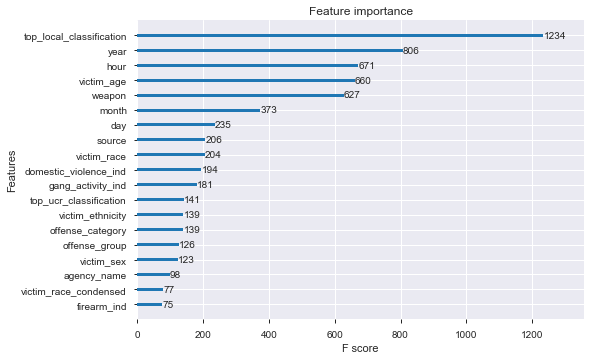

In [122]:
xgb.plot_importance(model);

# Conclusion

In conclusion, these data clearly show that X.